## Import required packages 

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

## Import data from AWS and prepare for processing

In [2]:
df = pd.read_csv('https://mod4finalproject.s3.amazonaws.com/zillow_cleaned_no_nulls.csv',
                   index_col=0,
                   dtype = {'zip':'object'})

In [3]:
df.index = pd.to_datetime(df.index)

In [4]:
df.columns

Index(['regionid', 'zip', 'city', 'state', 'metro', 'countyname', 'sizerank',
       'value'],
      dtype='object')

In [5]:
df = df.drop(columns = ['regionid', 'city', 'state', 'metro', 'countyname', 'sizerank'])

In [6]:
d2011 = '2011-05-01'
d2018 = '2018-04-01'

In [7]:
df = df[d2011:d2018]

## Define top 5 zip codes

In [8]:
top_zips = ['33976', '33974', '47353', '71263', '67860']

In [9]:
df = df.loc[df.zip.isin(top_zips)]

## Define functions for use in analysis

In [ ]:
plot_zip()

In [17]:
def plot_zip(df,zipcode, start, end):
    """
    Parameters:
    """
    zip_df = df.loc[df['zip']==zipcode]
    zip_df = zip_df.loc[(zip_df.index >= start) & (zip_df.index <= end)]
    sns.set(rc={'figure.figsize':(15,5)}, style='darkgrid')
    sns.lineplot(x=zip_df.index, y=zip_df.value)
    return plt.show()

In [18]:
def plot_diff(df, zipcode, start, end, lag):
    zip_df = df.loc[df['zip'] == zipcode]
    zip_df = zip_df.loc[(zip_df.index >= start) & (zip_df.index <= end)] 
    zip_df['diff'] = zip_df.value - zip_df.value.shift(lag)
    sns.set(rc={'figure.figsize':(15,5)}, style='darkgrid')
    plot = sns.lineplot(x=zip_df.index, y=zip_df['diff'])
    return plt.show()

In [19]:
def get_zip_df(df, zipcode, start, end):
    zip_df = df.loc[df['zip']==zipcode]
    zip_df = zip_df.loc[(zip_df.index >= start) & (zip_df.index <= end)]
    return zip_df

In [20]:
def get_diff_df(df, zipcode, start, end, lag):
    diff_df = df.loc[df['zip'] == zipcode]
    diff_df = diff_df.loc[(diff_df.index >= start) & (diff_df.index <= end)] 
    diff_df['diff'] = diff_df.value - diff_df.value.shift(lag)
    diff_df = diff_df.dropna(axis=0)
    return diff_df

In [21]:
## Test functions
# diff_df(df, top_zips[0], d2011, d2018, 2)

In [22]:
## Test functions
# for z in top_zips:
#     diff_plot(df, z, d2011, d2018, 1)

## Analysis for Lehigh Acres, FL 33974

In [143]:
zipcode = '33974'
start = d2011
end = d2018
lag = 1
lehigh = get_zip_df(df, zipcode, start, end)

### Plot of values, monthly

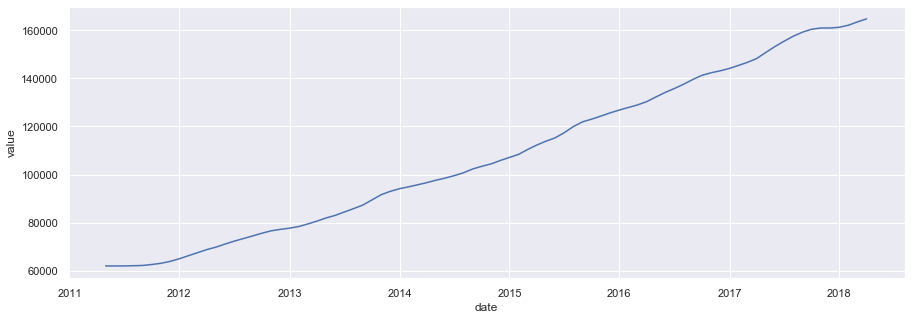

In [144]:
plot_zip(df, zipcode, start, end)

In [ ]:
plot_zip()

### Decomposition

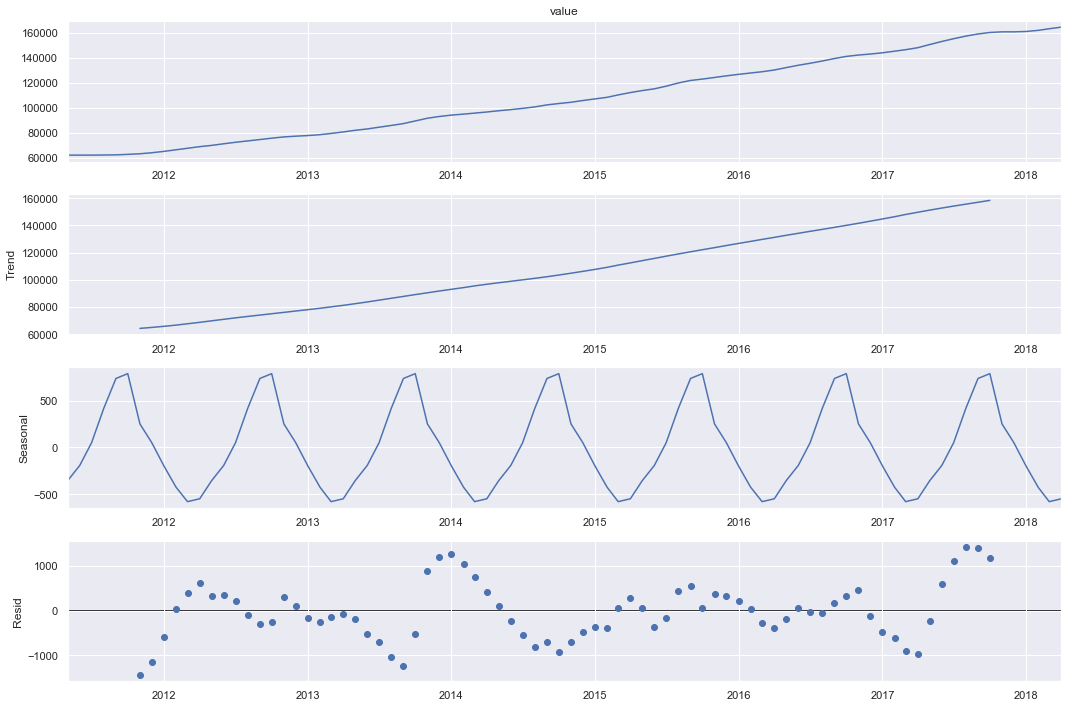

In [26]:
rcParams['figure.figsize'] = (15, 10)
result = seasonal_decompose(lehigh.value, model='additive')
result.plot()
plt.show()

### Plot of difference from lag

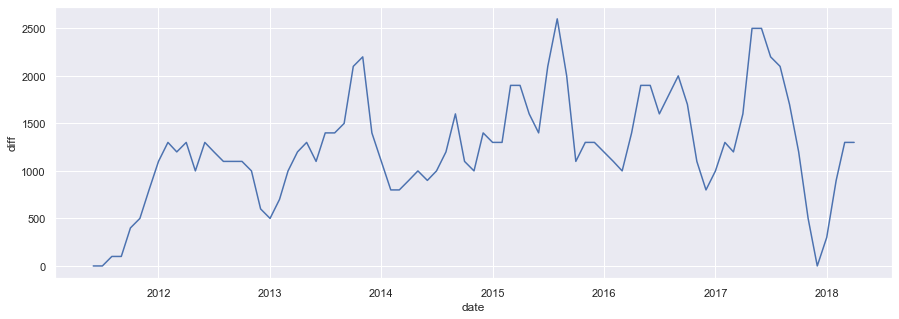

In [27]:
plot_diff(df, zipcode, start, end, lag)

### ACF and PACF for lag values

In [28]:
diff_df = get_diff_df(df, zipcode, start, end, lag)

### ACF (Pandas)

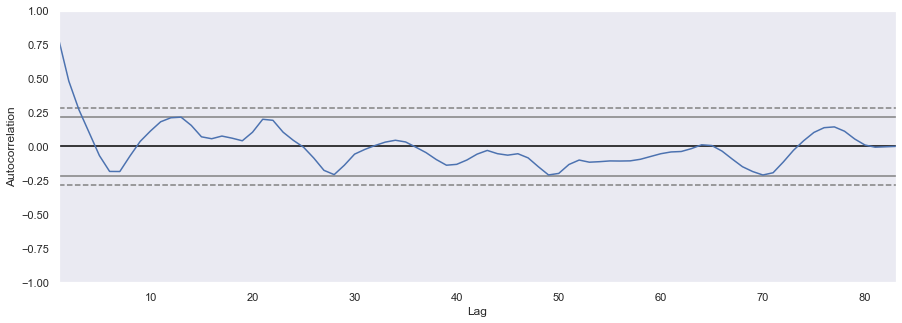

In [29]:
plt.figure(figsize=(15,5))
pd.plotting.autocorrelation_plot(diff_df['diff']);

### ACF (statsmodel)

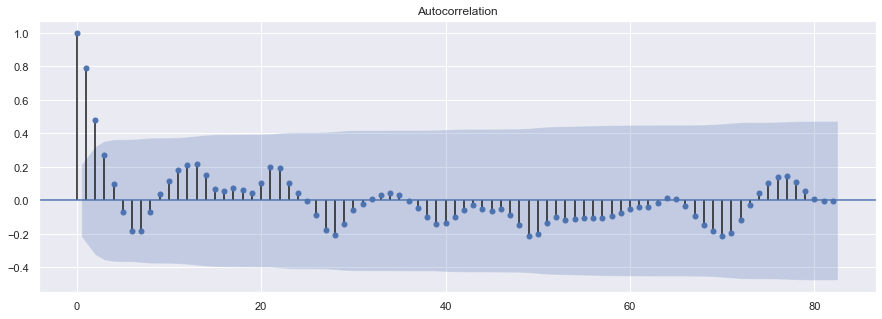

In [30]:
rcParams['figure.figsize'] = 15, 5
plot_acf(diff_df['diff'], lags=82);

### PACF (statsmodel)

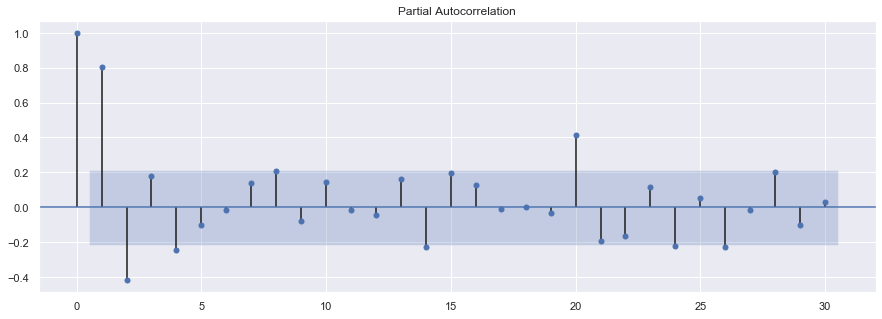

In [31]:
rcParams['figure.figsize'] = 15, 5
plot_pacf(diff_df['diff'], lags=30);

### Import train, val, test

In [32]:
pickle_in = open('../data/processed/train_val_test.pickle', 'rb')
train_val_test = pickle.load(pickle_in)

train = train_val_test[0]
val = train_val_test[1]
test = train_val_test[2]

In [33]:
train = train.loc[train.zip == zipcode]
val = val.loc[val.zip == zipcode]
test = test.loc[test.zip == zipcode]

In [34]:
train;

### ARIMA model
Looks like an AR(1) model based on ACF/PACF

In [167]:
model = ARIMA(train.value, order=(3,2,3))
model_fit = model.fit(disp=0)
model_fit.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.value   No. Observations:                   58
Model:                 ARIMA(3, 2, 3)   Log Likelihood                -404.242
Method:                       css-mle   S.D. of innovations            241.518
Date:                Thu, 07 May 2020   AIC                            824.485
Time:                        10:36:35   BIC                            840.968
Sample:                    07-01-2011   HQIC                           830.905
                         - 04-01-2016                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             19.0553      6.710      2.840      0.005       5.903      32.208
ar.L1.D2.value    -0.5129      0.135     -3.787      0.000      -0.778      -0.247
ar.L2.D2.value     0.2946      0.151      1.954      0.051      -0.001       0.590
ar.L3.D2.value     0.2721      0.141      1.928      0.054      -0.005       0.549
ma.L1.D2.value     0.7622      0.102      7.460      0.000       0.562       0.962
ma.L2.D2.value    -0.7622      0.092     -8.246      0.000      -0.943      -0.581
ma.L3.D2.value    -1.0000      0.109     -9.139      0.000      -1.214      -0.786
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5807           -0.0000j            1.5807           -0.0000
AR.2           -1.3318           -0.7426j            1.5249           -0.4190
AR.3           -1.3318           +0.7426j            1.5249            0.4190
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.8811           -0.4729j            1.0000           -0.4216
MA.3           -0.8811           +0.4729j            1.0000            0.4216
-----------------------------------------------------------------------------
"""

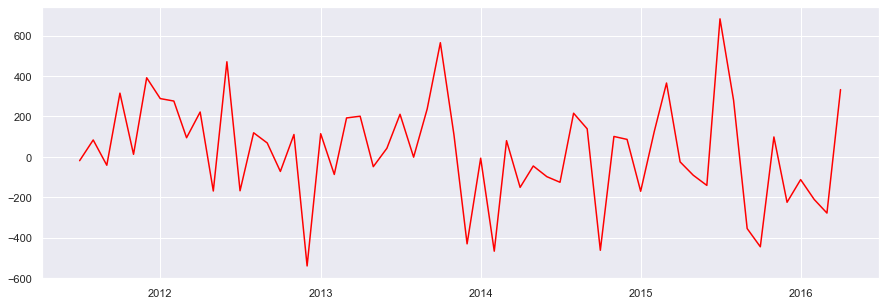

In [168]:
# plt.plot(np.array(diff_df['diff'])[0:60])
plt.plot(model_fit.resid, color='red')
plt.show()

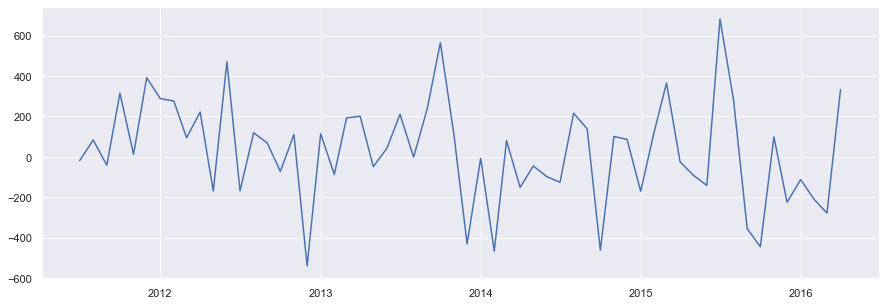

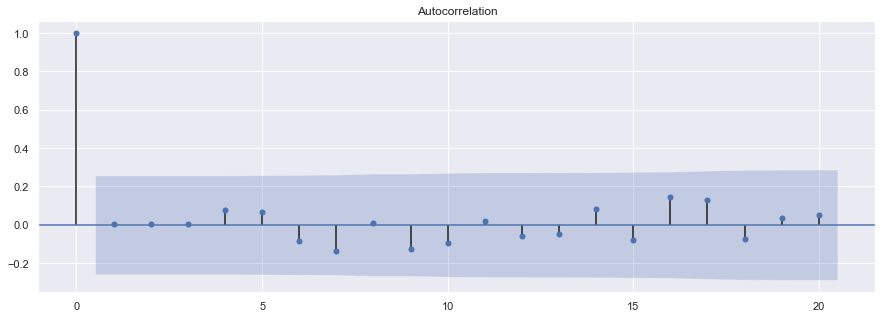

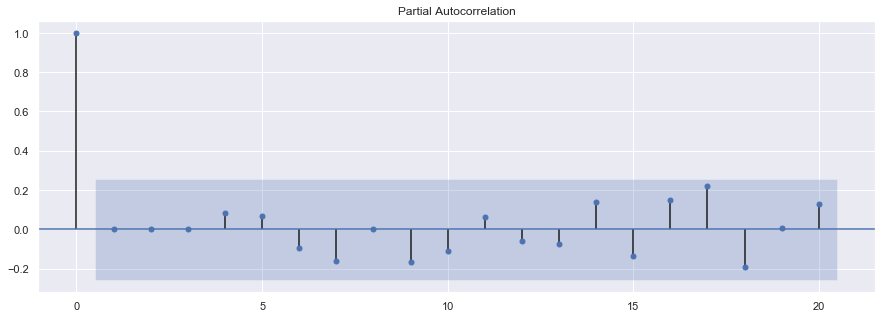

In [169]:
resid = model_fit.resid
plt.plot(resid)
plt.show()
rcParams['figure.figsize'] = 15, 5
plot_acf(resid, lags=20)
plt.show()
plot_pacf(resid, lags=20)
plt.show()

In [170]:
pred = model_fit.forecast(steps=24)
val_pred = pred[0][:12]
test_pred = pred[0][11:-1]

RMSE for Validation Period: 2054.357851726392


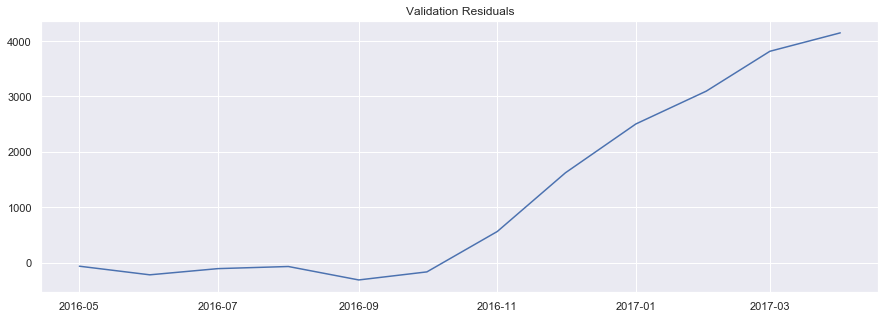

In [171]:
val_resid = val_pred - val.value
rmse = sqrt(mean_squared_error(val.value, val_pred))
print('RMSE for Validation Period: {}'.format(rmse))
plt.plot(val_resid)
plt.title('Validation Residuals')
plt.show()

RMSE for Test Period: 5547.537922523613


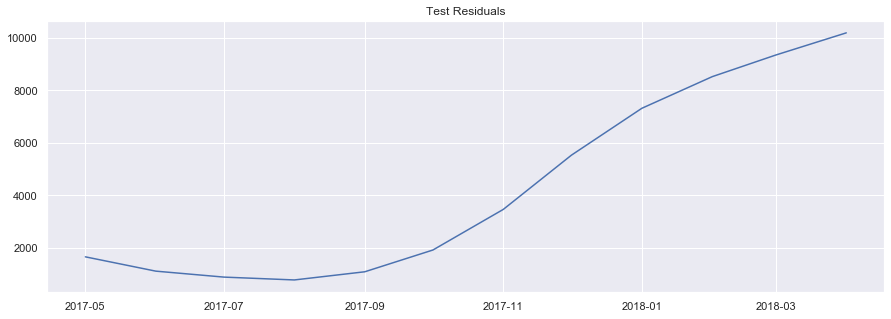

In [172]:
test_resid = test_pred - test.value
rmse = sqrt(mean_squared_error(test.value, test_pred))
print('RMSE for Test Period: {}'.format(rmse))
plt.plot(test_resid)
plt.title('Test Residuals')
plt.show()

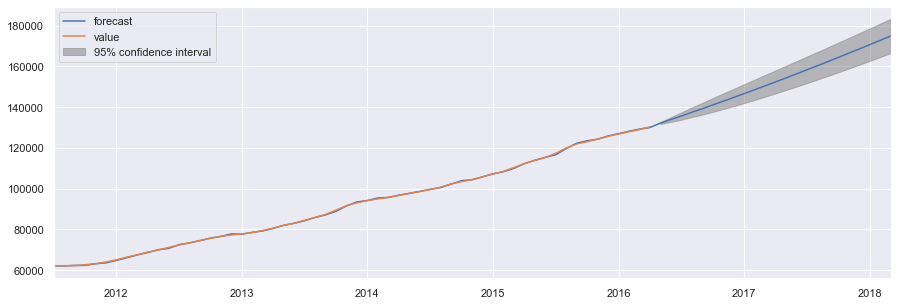

In [173]:
model_fit.plot_predict(2,82)
plt.show()

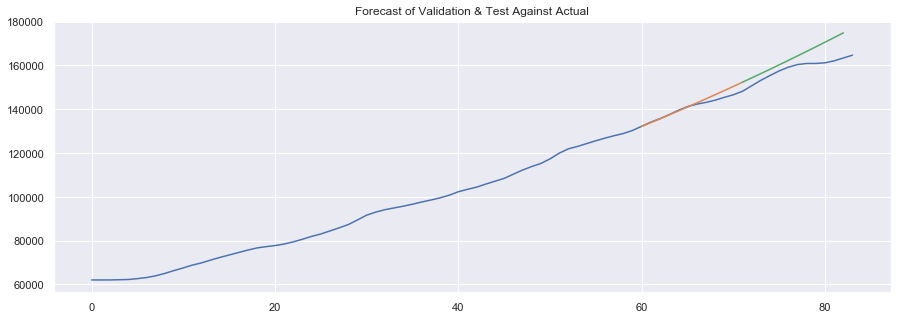

In [174]:
nan = np.full((60,1),np.nan)
nan1 = np.full((71,1),np.nan)
plt.plot(np.array(lehigh.drop('zip',axis=1)))
plt.plot(np.append(nan, val_pred))
plt.plot(np.append(nan1, test_pred))
plt.title('Forecast of Validation & Test Against Actual')
plt.show()